In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import matplotlib
from utils import download_datasets

In [2]:
#datasets
datasets_urls_boston = [
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/reviews.csv.gz'
]

datasets_urls_seattle = [
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/reviews.csv.gz'
]
datasets_urls_austin = [
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/reviews.csv.gz'
]

download_datasets(datasets_urls_boston, 'boston_')
download_datasets(datasets_urls_seattle, 'seattle_')
download_datasets(datasets_urls_austin, 'austin_')


datasets_cities = [
    'seattle',
    'boston',
    'austin'
]

datasets_cities = ['seattle', 'boston', 'austin']

File: boston_listings.csv.gz, in cache
File: boston_calendar.csv.gz, in cache
File: boston_reviews.csv.gz, in cache
File: seattle_listings.csv.gz, in cache
File: seattle_calendar.csv.gz, in cache
File: seattle_reviews.csv.gz, in cache
File: austin_listings.csv.gz, in cache
File: austin_calendar.csv.gz, in cache
File: austin_reviews.csv.gz, in cache


In [3]:
#Reading files


listings = []
calendar = []
reviews = []

for city in datasets_cities:
    listings += [pd.read_csv(city+'_listings.csv.gz', index_col=0)]
    calendar += [pd.read_csv(city+'_calendar.csv.gz', parse_dates=['date'])]
    reviews  += [pd.read_csv(city+'_reviews.csv.gz')]

listings = pd.concat(listings)
calendar = pd.concat(calendar)
reviews = pd.concat(reviews)



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## Basics stats
print("Count of listings")
print(listings.count()[0])
print("Calendar has every listing?")
print(listings.count()[0] == calendar.groupby("listing_id").all().count()[0])


Count of listings
25970
Calendar has every listing?
True


In [5]:
#transform 't' or 'f' into True or False values.
calendar.available = calendar.available.apply(lambda x: x == "t")
#remove $ sign and parse the value as numeric.
calendar.price = calendar.price.apply(lambda x: float(str(x).replace("$","").replace(",","")))

calendar.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
dtype: object

In [6]:
null_percent_price = calendar.price.isnull().sum() / (calendar.price.shape[0])

print("Percent of null elements in the price column: ", null_percent_price)

Percent of null elements in the price column:  0.6196350900142947


In [7]:
#
def variation_metric(data):
    x = data.copy()
    x = x.dropna()
    x = x['price'].values
    if x.shape[0] == 0:
        return np.nan
    
    var_score = 0
    last_val = x[0]
    
    for val in x[1:]:
        if last_val != val:
            var_score += 1
        last_val = val
    
    return var_score
  
def minmax_metric(data):
    x = data.copy()
    x = x.dropna()
    if x.shape[0] == 0:
        return np.nan
    return x.price.min()/x.price.max()

def availability_metric(data):
    available_count = data[data.available == True]['available'].sum()
    return available_count/data.available.shape[0]

def std_metric(data):
    return data.price.std()
    
def mean_metric(data):
    return data.price.mean()

min_max = calendar.groupby('listing_id').apply(lambda x: minmax_metric(x))
variation = calendar.groupby('listing_id').apply(lambda x: variation_metric(x))
available = calendar.groupby('listing_id').apply(lambda x: availability_metric(x))
std = calendar.groupby('listing_id').apply(lambda x: std_metric(x))
mean = calendar.groupby('listing_id').apply(lambda x: mean_metric(x))

,min_max,variation,available,std,mean
id,,,,,
2265,0.727273,4.0,0.298630,24.300003,209.862385
2318,0.592000,6.0,0.901370,55.673626,319.106383
3781,0.833333,25.0,0.246575,11.260312,131.944444
4291,1.000000,0.0,0.953425,0.000000,82.000000
5245,0.714286,2.0,0.400000,13.780107,129.109589
5456,0.271429,58.0,0.884932,64.182727,134.272446
5506,0.580000,3.0,0.841096,13.312418,146.723127
5682,0.684211,8.0,0.060274,5.439355,55.590909
5769,0.909091,10.0,0.178082,1.074843,40.430769


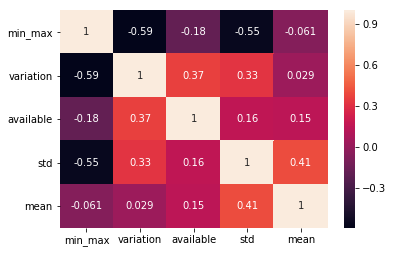

In [8]:
min_max.name = "min_max"
variation.name = "variation"
available.name = "available"
std.name = "std"
mean.name = "mean"

combined_metrics = pd.concat([min_max, variation, available, std, mean], axis=1).dropna()
sns.heatmap(combined_metrics.corr(), annot=True);
combined_metrics.index.name = "id"
display(combined_metrics)

In [9]:
listings_merged = pd.merge(combined_metrics, listings, on='id')

In [10]:
corr_matrix = listings_merged.corr()
corr_matrix.style.background_gradient()

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,min_max,variation,available,std,mean,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
min_max,1,-0.590184,-0.182885,-0.554707,-0.0606116,0.0909683,nan,nan,nan,-0.0308548,nan,-0.327463,-0.327463,0.130008,-0.0797952,-0.244826,-0.0742566,-0.118262,-0.198674,0.175817,-0.204318,0.102989,-0.00457111,-0.131042,-0.155632,-0.167402,-0.182885,-0.11861,0.0621011,0.0481651,-0.0452254,0.0676414,0.0611305,-0.0630056,0.0809727,-0.279455,-0.133159
variation,-0.590184,1,0.371571,0.325668,0.0288452,-0.0366476,nan,nan,nan,0.0463471,nan,0.305274,0.305274,-0.0221614,-0.0241222,0.163339,0.038526,0.0730043,0.131654,-0.147358,0.160131,-0.0648096,0.000806489,0.114857,0.168822,0.206188,0.371571,0.0742349,-0.0932376,-0.0850092,0.0110598,-0.101164,-0.0846628,0.0153371,-0.100725,0.250376,0.07078
available,-0.182885,0.371571,1,0.158907,0.14698,-0.112908,nan,nan,nan,-0.0428978,nan,0.0631671,0.0631671,-0.136897,0.0538621,0.122115,0.123731,0.109745,0.119221,0.247507,0.101099,0.0860368,-0.00121166,0.329901,0.410294,0.469719,1,-0.00941671,-0.0562422,-0.0652269,-0.0328957,-0.0401181,-0.062394,-0.0354811,-0.0787811,-0.00657005,-0.166246
std,-0.554707,0.325668,0.158907,1,0.405864,-0.109483,nan,nan,nan,0.0524522,nan,0.175844,0.175844,-0.156505,0.0964186,0.45769,0.341022,0.374871,0.430203,0.279052,0.376059,-0.00705613,0.00189609,0.125882,0.119097,0.112756,0.158907,-0.0301125,-0.0162579,-0.0324981,0.023242,-0.0338338,-0.0444934,0.038132,-0.0690963,0.157556,-0.0378512
mean,-0.0606116,0.0288452,0.14698,0.405864,1,-0.122927,nan,nan,nan,0.0112338,nan,0.0799527,0.0799527,-0.156618,0.0728731,0.503,0.534496,0.511101,0.456707,0.544958,0.33648,0.00471849,-0.00133845,0.18811,0.163431,0.141365,0.14698,-0.128399,0.0343253,-0.0120589,0.0354463,-0.0203862,-0.032909,0.0542247,-0.0660998,0.100283,-0.181673
scrape_id,0.0909683,-0.0366476,-0.112908,-0.109483,-0.122927,1,nan,nan,nan,0.00087162,nan,0.194907,0.194907,0.850943,0.196992,-0.201459,-0.177613,-0.1981,-0.173511,-0.333746,-0.177669,0.0013752,-0.00781124,-0.333131,-0.256528,-0.207727,-0.112908,0.0827789,-0.183219,-0.119394,-0.0833189,-0.0969617,-0.111659,-0.0939947,-0.168401,0.237207,0.154548
thumbnail_url,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
medium_url,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
xl_picture_url,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
host_id,-0.0308548,0.0463471,-0.0428978,0.0524522,0.0112338,0.00087162,nan,nan,nan,1,nan,-0.0855426,-0.0855426,-0.022954,0.0446522,0.0470982,0.0295961,0.0236318,0.0492188,-0.197672,0.07092,-0.0327081,-0.00645961,0.00828125,0.0206801,0.0225303,-0.0428978,-0.201837,-0.0261485,-0.0246,-0.0224593,-0.0260386,-0.0322776,-0.0101916,-0.0159027,-0.106839,0.149761


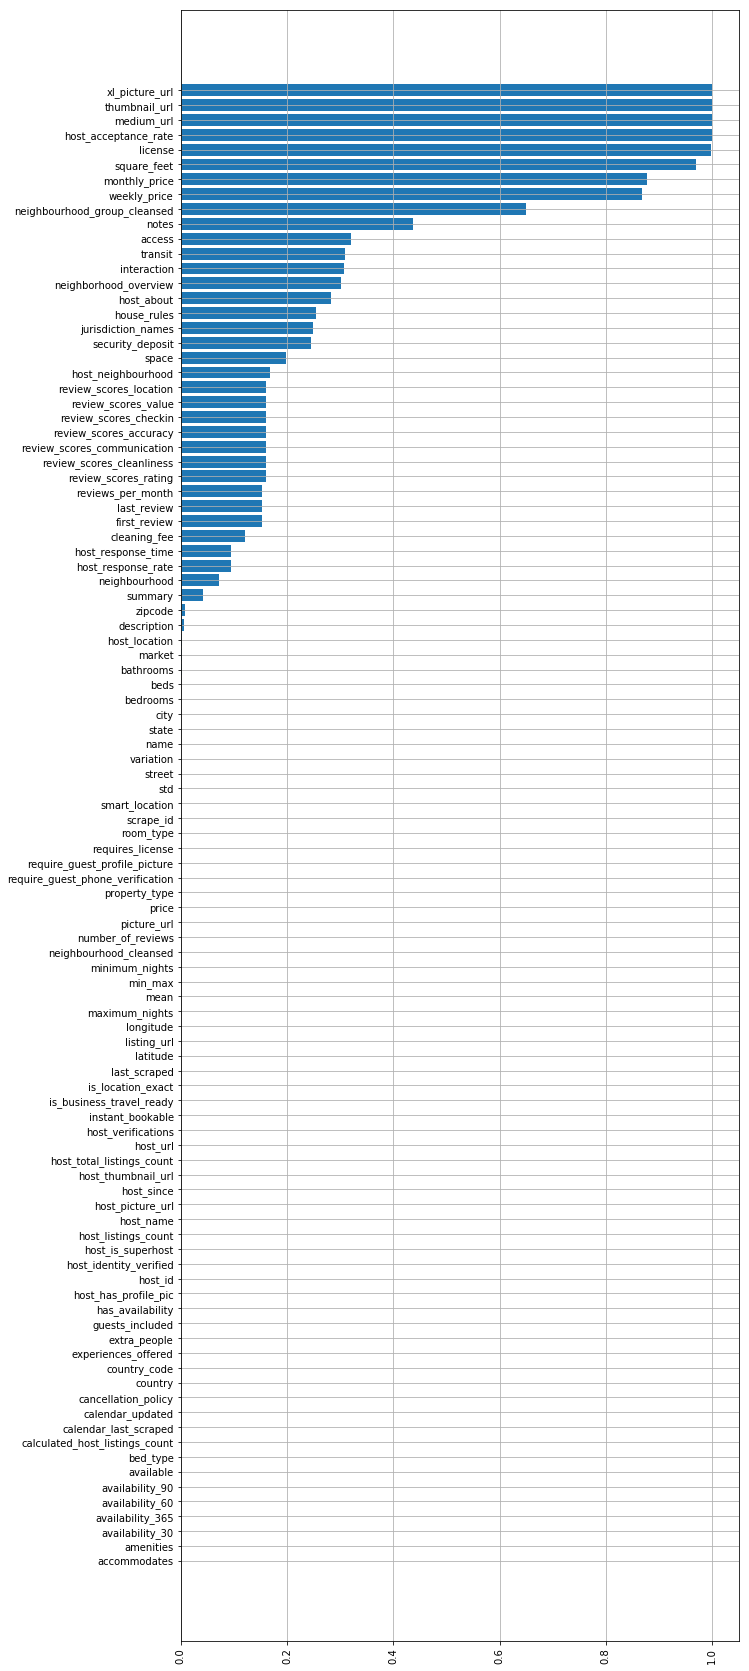

In [11]:
#Getting null % for each feature

def show_nan_percentage(df, figsize=(10, 30)):
    labels_ = []
    values_ = []

    for feature in df.columns:
        nulls_percentage = df[feature].isna().mean()
        labels_ += [feature]
        values_ += [nulls_percentage]

    values_, labels_ = zip(*sorted(zip(values_, labels_)))

    plt.figure(1, figsize=figsize)
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.barh(labels_, values_)
    plt.show();

show_nan_percentage(listings_merged)

In [12]:
remove_from = 0.6
to_remove = ["host_id","scrape_id","latitude","longitude"]
for feature in listings_merged.columns:
    nulls_percentage = listings_merged[feature].isna().mean()
    if nulls_percentage >= remove_from:
        to_remove += [feature]
listings_droped_cols = listings_merged.drop(to_remove, axis=1)

In [13]:
for col in listings_droped_cols.select_dtypes(include=np.object):
    display(listings_droped_cols[col].sample(10))


id
22529947    https://www.airbnb.com/rooms/22529947
23085831    https://www.airbnb.com/rooms/23085831
16700978    https://www.airbnb.com/rooms/16700978
3009469      https://www.airbnb.com/rooms/3009469
17461777    https://www.airbnb.com/rooms/17461777
27665637    https://www.airbnb.com/rooms/27665637
19594262    https://www.airbnb.com/rooms/19594262
352029        https://www.airbnb.com/rooms/352029
22533216    https://www.airbnb.com/rooms/22533216
21000901    https://www.airbnb.com/rooms/21000901
Name: listing_url, dtype: object

id
16438943    2018-08-16
19455685    2018-08-14
6325661     2018-08-14
7800238     2018-08-16
10268403    2018-08-14
24328998    2018-08-14
27593871    2018-08-17
19430067    2018-08-17
10175033    2018-08-17
914783      2018-08-14
Name: last_scraped, dtype: object

id
26638649                                Zilker Stone Cottage
6317722                  Brand New 2 BR | 1 BA in So. BOS #3
13045179                            Theo & Maria's Red House
4151271                    CLASSIC CASITA  CLOSE TO DOWNTOWN
5760430                           Eco-Friendly MIL Apartment
20744258       Beautiful one bedroom apt on theater district
10540208        Enjoy the Scenery from Palatial Estate House
15341441           Simple 1BR in Downtown Crossing by Sonder
4263947     Enjoy Austin from a Fun Duplex with Quirky Decor
26469790                 Enchanted Garden Home- Private Room
Name: name, dtype: object

id
15282690    These high end apartments are located right wh...
5806636     Welcome to Austin and The Chelsea Cottage Unit...
21005292    Contemporary farmhouse in central Austin, Texa...
8154238     Built, run and supported by Seattle tech and s...
9303743     Never a dull moment at this one ,The perfect g...
5105452     Lots of amenities-tv, mini fridge, microwave, ...
20075718    Great apartment with awesome location. The apa...
23439881    PRIVATE LUXURY retreat in Brentwood. Beautiful...
13397569    Comfortable 1 bed, 1 bath with kitchen and ful...
13020298    Gorgeous light and airy townhouse in desirable...
Name: summary, dtype: object

id
13379950    The space Excellent location in Seattle. Walki...
23983000    We are available to assist you with absolutely...
13687977    My home is pleasant, mellow & clean.  Nicely d...
134091      Old world charm meets modern elegance. Welcome...
2114274     We live in a brownstone apartment with two lar...
15206282    Every booking is instantly confirmed. Every ca...
20189858    Located in Downtown Boston, this apartment is ...
12913085    Two large bedrooms, with king size beds, one c...
13730506    The house is brand spanking new and outfitted ...
1332786     We live in an 18 room 160 year old house that ...
Name: space, dtype: object

id
7750253     5 minute cab to Boston Convention Center &  Wo...
14367760    Our place was built in 2008 and is located in ...
18545927    This Queen Anne suite is located arguably in t...
867806      Enjoy this beautifully constructed new flat. Y...
23293607    This sleek three-story home is walking distanc...
10789137    Super comfortable private room with shared bat...
23520923    The Green bedroom, 13 miles to the airport & 9...
16132916    Steps to Beach, blocks to shops, minutes to Do...
14442491    My place is close to Top of the Hub, The Shops...
2501888     Sofa bed in the media room on the first floor....
Name: description, dtype: object

id
20479407    none
25252113    none
13115533    none
22496752    none
8582599     none
4294376     none
16860853    none
104386      none
22337420    none
27519547    none
Name: experiences_offered, dtype: object

id
20137158    This is a funky, multicultural diverse  neighb...
13176423    We're close to the light rail, but you might n...
1725964     The neighborhood is great because it's so quie...
27370110    We live in a quiet, safe, and tranquil residen...
140651      The house is located in a quiet neighborhood o...
25748121                                                  NaN
27736223             Next to park,  jogging and biking trail.
22530470    We are in the Bitter Lake area of Seattle.  Ne...
11639480                                                  NaN
23140272    Major Attractions: •\tRestaurants – Shabu-Zen ...
Name: neighborhood_overview, dtype: object

id
22000425    Our space provides guests with a comfortable s...
24596837    Parking is designated in front of the house. E...
21861781    70 Parker Hill Avenue is located directly besi...
18212584                                                  NaN
2324317     PETS: Sorry, no cats. Well-behaved dogs (2 max...
13099011    We are a licensed and inspected bed and breakf...
24649475                                                  NaN
10175033    There are three flights of stairs and no eleva...
21440119    right in the middle of Seattle's Ballard-Fremo...
8848315                  Plenty of parking, patio for smoking
Name: notes, dtype: object

id
26895068    2 minutes walk to bus station 7 minute drive t...
5276944     Uber is the fastest most affordable way to get...
17011547    If driving there is plenty of street parking r...
27025549                                                  NaN
27527176                                                  NaN
8812578     Yup! 2 blocks to the streetcar and a couple of...
3812957     Right next to the Capitol Hill Lite Rail train...
12131039                                                  NaN
11547507                                                  NaN
18820537    Chinatown, a lot of choices there , Couldn’t l...
Name: transit, dtype: object

id
5749958     Live the Ballard neighborhood experience in ou...
21960882                                                  NaN
1627417     Please park in the empty garage space. The doo...
22750596                                                  NaN
21565505    Lobby, unit and private bath. Coin operated wa...
27023519    You'll have your own private apartment, with b...
20680261                                                  NaN
26995516    Guests have access  to the swimming pool, fitn...
20744258                                  All areas ok to use
27132095             Casita, back yard, and lower patio area.
Name: access, dtype: object

id
26841132                                                  NaN
18241507    I love to help guests with local restaurants a...
26057807    Most of the time I won't be far away, but if I...
8102349     Interaction with guest will be limited, as we ...
15111676                                                  NaN
12929985    I love to travel and host travelers. I can be ...
16348637                                                  NaN
20881263    There will be an orientation check in and can ...
734163                                                    NaN
24728697    We live in the basement that is accessed by a ...
Name: interaction, dtype: object

id
1747780                                                   NaN
6886633     The El Rey is older than my parents and it mig...
14790057    The house is shared with two guys in their lat...
22151541    - You agree to the following: -  - CHECK-IN: i...
9261455     ｡If you open it, close it; if you borrow it, r...
22121305    House Rules 1. All bookings require a security...
13451764    The only rule is the golden rule.....treat the...
3278624     Please remember that this is a residential bui...
27641616    Guests must be over the age of 21 and will be ...
19599031    Smoking is allowed on deck only.  not in Apart...
Name: house_rules, dtype: object

id
15041151    https://a0.muscache.com/im/pictures/a66c774d-e...
4938126     https://a0.muscache.com/im/pictures/a5878dcd-5...
17653279    https://a0.muscache.com/im/pictures/26b583a9-c...
19097632    https://a0.muscache.com/im/pictures/de3954c2-d...
9031119     https://a0.muscache.com/im/pictures/a85bed4c-7...
20625690    https://a0.muscache.com/im/pictures/4e4edf08-6...
9343915     https://a0.muscache.com/im/pictures/f326e801-3...
27174044    https://a0.muscache.com/im/pictures/e592924e-a...
710036      https://a0.muscache.com/im/pictures/9800193/85...
16352510    https://a0.muscache.com/im/pictures/0d73cf21-2...
Name: picture_url, dtype: object

id
10653503       https://www.airbnb.com/users/show/149281
4341078        https://www.airbnb.com/users/show/320518
22013722    https://www.airbnb.com/users/show/160748778
7922013      https://www.airbnb.com/users/show/41775435
18220922    https://www.airbnb.com/users/show/109638288
746317        https://www.airbnb.com/users/show/1840480
17184475    https://www.airbnb.com/users/show/112448661
20999512     https://www.airbnb.com/users/show/28013686
6290509      https://www.airbnb.com/users/show/27189459
25627777    https://www.airbnb.com/users/show/177821967
Name: host_url, dtype: object

id
22260527                 Mike
19228005               Sharon
3965313                   May
4461846              Maverick
21437004                Nadia
13236936                 Jean
23823040    Danielle And Alex
23172356                  Val
25203922                Yokke
13514630                Chris
Name: host_name, dtype: object

id
26167317    2014-05-20
2736478     2014-04-07
6134153     2014-03-26
21154279    2017-09-29
20322173    2017-07-31
17849739    2014-05-30
1629525     2013-09-05
27462072    2013-10-14
20194856    2017-08-01
12987793    2015-11-11
Name: host_since, dtype: object

id
23321269    San Francisco, California, United States
12901899                Austin, Texas, United States
20948213          Seattle, Washington, United States
2278704         Boston, Massachusetts, United States
11601819     Arlington, Massachusetts, United States
27372741                                          US
25911571          Seattle, Washington, United States
969561                  Austin, Texas, United States
5280717                 Austin, Texas, United States
20917797                Austin, Texas, United States
Name: host_location, dtype: object

id
23078707    Hello!\r\nI live in Brighton, a  neighborhood ...
24286056                                                  NaN
13972298    I work for Furnished Quarters, the largest pro...
21039284    Entrepreneur, Writer, Artist, PR & Business De...
6660186     I am outgoing, love to entertain and travel.  ...
23972696    It would be my pleasure to share and explore t...
22150881    Hello! As an avid travler and lover of Seattle...
7935687     Hello!  I am a native Austinite and LOVE our g...
18738103    Father of 2 young kids, love to walk and play ...
26899681    I'm a college graduate. Traveled some, lived i...
Name: host_about, dtype: object

id
18041563        within an hour
27054010    a few days or more
23507334    within a few hours
6850781         within an hour
22945853        within an hour
15235292        within an hour
22654177    within a few hours
3551836         within an hour
19436968        within an hour
26000552        within an hour
Name: host_response_time, dtype: object

id
4809486     100%
17008980    100%
17257163    100%
14556481     NaN
15496036     NaN
19329023    100%
14936941    100%
20026196    100%
26138283     99%
19547639    100%
Name: host_response_rate, dtype: object

id
23140272    f
10295151    f
27377735    t
19763798    f
1686930     t
22350678    f
5219336     f
24312216    f
5637168     f
11512875    f
Name: host_is_superhost, dtype: object

id
24331719    https://a0.muscache.com/im/users/8167447/profi...
24760291    https://a0.muscache.com/im/pictures/user/4ccaf...
17777744    https://a0.muscache.com/im/pictures/9a6d7397-c...
4025305     https://a0.muscache.com/im/users/8143598/profi...
8542056     https://a0.muscache.com/im/users/44939694/prof...
27516676    https://a0.muscache.com/im/pictures/16d82a56-f...
24701321    https://a0.muscache.com/im/pictures/user/198fa...
2760312     https://a0.muscache.com/im/users/14107195/prof...
26848107    https://a0.muscache.com/im/pictures/5c1348d7-7...
26355646    https://a0.muscache.com/im/users/21781360/prof...
Name: host_thumbnail_url, dtype: object

id
21414431    https://a0.muscache.com/im/users/9663343/profi...
20035353    https://a0.muscache.com/im/pictures/b6cb2775-a...
5524366     https://a0.muscache.com/im/users/4543072/profi...
23582347    https://a0.muscache.com/im/pictures/user/16907...
24632540    https://a0.muscache.com/im/pictures/user/72f5b...
6560787     https://a0.muscache.com/im/pictures/9ba64388-c...
5928709     https://a0.muscache.com/im/pictures/user/b9e30...
24990505    https://a0.muscache.com/im/pictures/user/0ed5b...
16338772    https://a0.muscache.com/im/pictures/0b62d199-b...
12194423    https://a0.muscache.com/im/users/3353143/profi...
Name: host_picture_url, dtype: object

id
241016               Queen Anne
26450608            Gay Village
14251275       Allston-Brighton
783376              Parker Lane
4084746                  Zilker
22308772       South Lake Union
8939595     University District
14808631            Beacon Hill
26194842    University District
15004681            Clarksville
Name: host_neighbourhood, dtype: object

id
22296394    ['email', 'phone', 'reviews', 'jumio', 'govern...
15657570                        ['email', 'phone', 'reviews']
6183330                         ['email', 'phone', 'reviews']
6795678                  ['email', 'phone', 'reviews', 'kba']
362525       ['email', 'phone', 'facebook', 'reviews', 'kba']
16156516                        ['email', 'phone', 'reviews']
20993429    ['email', 'phone', 'reviews', 'jumio', 'offlin...
24219045    ['email', 'phone', 'google', 'reviews', 'jumio...
25377648    ['email', 'phone', 'reviews', 'kba', 'work_ema...
21238984    ['email', 'phone', 'manual_offline', 'jumio', ...
Name: host_verifications, dtype: object

id
76309       t
2989616     t
22958194    t
5871963     t
7662548     t
22119637    t
22225757    t
20269943    t
23809259    t
20931768    t
Name: host_has_profile_pic, dtype: object

id
27257856    t
20935862    t
21460876    f
21053806    t
21346818    f
10606818    f
14966475    f
1652097     t
23667548    t
12269155    f
Name: host_identity_verified, dtype: object

id
21295435      Austin, TX, United States
22030644      Boston, MA, United States
5168047       Austin, TX, United States
15007914      Austin, TX, United States
27062651     Seattle, WA, United States
20930699      Austin, TX, United States
21350397      Boston, MA, United States
15565516      Austin, TX, United States
25904410      Boston, MA, United States
3226987     Bee Cave, TX, United States
Name: street, dtype: object

id
8035212                   NaN
25997143        East Downtown
23293607        East Downtown
21924222     Lower Queen Anne
4567243             Greenwood
19764464              Stevens
26232515       East Riverside
17369527    SW Williamson Co.
26624750                  NaN
22276253             West End
Name: neighbourhood, dtype: object

id
24598890                     Mattapan
969565                          78703
22350678      South Boston Waterfront
4778238                         78704
10247453    Central Business District
973664                          78704
16269873                   Dorchester
21554511                  East Boston
27676525                        78702
16190079                        78705
Name: neighbourhood_cleansed, dtype: object

id
20306021    Lakeway
18615279    Seattle
18636268    Seattle
23222356     Austin
16220910     Austin
14935978     Boston
23697390     Austin
21484882    Seattle
2297917     Seattle
11144738     Austin
Name: city, dtype: object

id
16998097    WA
22408657    MA
22228885    MA
11089653    WA
295275      TX
27578322    TX
10132073    MA
26722859    WA
19980588    TX
12366420    TX
Name: state, dtype: object

id
19763798    78701
24119742    78705
16353151    98106
11523081    78745
16883362    98109
17095852    78705
18913454    78701
19970485    98133
18266072    78701
13236936    02124
Name: zipcode, dtype: object

id
2380176      Austin
639111       Boston
14975916     Boston
21382777    Seattle
17634857     Austin
26066073     Boston
958210       Austin
9910025     Seattle
25734291     Austin
27133697     Austin
Name: market, dtype: object

id
190984      Seattle, WA
25965097    Seattle, WA
16693267    Seattle, WA
9424500      Austin, TX
3868266      Austin, TX
8156860     Seattle, WA
20030072     Austin, TX
21731135    Seattle, WA
16870359     Boston, MA
22532117     Boston, MA
Name: smart_location, dtype: object

id
25817486    US
26742322    US
19967544    US
22012439    US
27658371    US
7287162     US
8805211     US
4129218     US
22325855    US
17388105    US
Name: country_code, dtype: object

id
15821724    United States
887228      United States
2447757     United States
25867686    United States
22266038    United States
16438314    United States
19849023    United States
17492633    United States
24730153    United States
910957      United States
Name: country, dtype: object

id
16453747    t
6780756     t
19455685    t
21475173    t
2657000     t
23983010    t
17415612    t
1039766     t
1743366     t
27327646    t
Name: is_location_exact, dtype: object

id
22615702      Apartment
24015983    Condominium
26713740      Apartment
13961307    Condominium
3783162           House
23250064      Apartment
13042308          House
27555535      Apartment
25096768          House
6274351           House
Name: property_type, dtype: object

id
7239024        Private room
12665563    Entire home/apt
8388876        Private room
26155768       Private room
26168827    Entire home/apt
26870587    Entire home/apt
3124593     Entire home/apt
5124417     Entire home/apt
18873273       Private room
21726603    Entire home/apt
Name: room_type, dtype: object

id
11944943    Real Bed
20649310    Real Bed
6854216     Real Bed
14750497    Real Bed
16943185    Real Bed
25320618    Real Bed
23579516    Real Bed
23411737    Real Bed
13699809    Real Bed
18873614    Real Bed
Name: bed_type, dtype: object

id
20436494    {Internet,Wifi,"Air conditioning",Kitchen,Heat...
17256958    {TV,Internet,Wifi,Kitchen,"Free street parking...
21693944    {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
19473894    {TV,Wifi,"Air conditioning",Kitchen,"Free park...
6387576     {Wifi,"Paid parking off premises",Heating,"Smo...
25077013    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
19878428    {Wifi,Kitchen,"Pets live on this property",Dog...
23681506    {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
25076991    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
22450357    {TV,Wifi,Pool,Kitchen,"Free parking on premise...
Name: amenities, dtype: object

id
26668910     $50.00
25424326    $150.00
16037167    $600.00
23230125     $48.00
23797507    $110.00
9425087     $429.00
25580596     $65.00
23342054     $60.00
2701124     $280.00
7387294      $70.00
Name: price, dtype: object

id
26419561        NaN
26256304      $0.00
25024721      $0.00
14281130        NaN
9512909       $0.00
8507559     $150.00
26526206        NaN
20135997    $250.00
19222993    $250.00
24137239    $150.00
Name: security_deposit, dtype: object

id
23304766        NaN
17188559     $25.00
6268805     $100.00
25113399     $20.00
10922191     $30.00
20309505     $40.00
8422925      $35.00
22945908    $219.00
22746030     $15.00
27552353        NaN
Name: cleaning_fee, dtype: object

id
24397958     $5.00
24631987    $20.00
21665277    $15.00
13508899    $20.00
27607986    $10.00
25077004     $0.00
15854065     $0.00
11611131     $0.00
27571966     $0.00
19658942     $0.00
Name: extra_people, dtype: object

id
7902005       yesterday
22497982    2 weeks ago
20607756     3 days ago
4955455      a week ago
21025055          today
21459302          today
23518914          today
26259689     a week ago
27459746          today
27231517     a week ago
Name: calendar_updated, dtype: object

id
15375825    t
20805317    t
19998942    t
23398832    t
8933249     t
24825705    t
7224920     t
24221823    t
24358544    t
19908226    t
Name: has_availability, dtype: object

id
17604822    2018-08-14
5637928     2018-08-14
22192442    2018-08-17
16628934    2018-08-14
10575430    2018-08-17
7713043     2018-08-16
15057544    2018-08-16
7389950     2018-08-16
17641921    2018-08-14
21198412    2018-08-17
Name: calendar_last_scraped, dtype: object

id
23187118    2018-04-24
486829      2012-06-08
19967544    2017-09-17
20355929    2017-08-11
8036024     2015-09-09
751847      2014-05-27
6938778     2015-06-27
22190735    2018-01-07
23881963    2018-06-21
27173882    2018-08-13
Name: first_review, dtype: object

id
1861070     2018-06-24
16287480    2018-08-07
17358165    2018-08-05
20662961    2018-07-31
23272168           NaN
23088453    2018-07-27
24916335           NaN
21280012    2018-07-01
2390894     2018-06-27
23854083           NaN
Name: last_review, dtype: object

id
23838806    f
4359747     f
367356      f
20117880    f
22656172    f
4085297     f
72633       f
14554889    f
2832087     f
21713058    f
Name: requires_license, dtype: object

id
25870859                NaN
25078262    {"Texas State"}
25902519       {WASHINGTON}
27270094       {WASHINGTON}
10062315    {"Texas State"}
25033197       {WASHINGTON}
27672675                NaN
20327028       {WASHINGTON}
17907723       {WASHINGTON}
18705205                NaN
Name: jurisdiction_names, dtype: object

id
14167866    t
19015514    t
948077      t
27584770    t
14216338    f
16638438    t
17021404    t
16998097    f
12095601    f
17436077    f
Name: instant_bookable, dtype: object

id
12495915    f
11167826    f
12288101    f
1027860     f
10882393    f
15163385    f
639130      f
5085831     f
2071305     f
16291240    f
Name: is_business_travel_ready, dtype: object

id
13626295                       moderate
12812601    strict_14_with_grace_period
25092614                super_strict_30
26594507                       moderate
14928081                       moderate
26418410                       flexible
14590623                       moderate
20726692    strict_14_with_grace_period
6108796     strict_14_with_grace_period
27211392    strict_14_with_grace_period
Name: cancellation_policy, dtype: object

id
24022545    f
22432115    f
669923      f
23983006    t
25053266    f
21840175    f
22608674    f
20281822    f
20868619    f
14253492    f
Name: require_guest_profile_picture, dtype: object

id
17942707    f
22342006    f
22213875    f
20285652    f
11303784    f
23378695    f
4243715     f
16973996    f
17703491    f
6248970     f
Name: require_guest_phone_verification, dtype: object

In [14]:
non_numerical_cols_example = ['host_since',
                      'host_response_rate',
                      'host_is_superhost',
                      'host_verifications',
                      'host_has_profile_pic',
                      'host_identity_verified',
                      'zipcode',
                      'is_location_exact',
                      'property_type',
                      'room_type',
                      'bed_type',
                      'amenities',
                      'security_deposit',
                      'cleaning_fee',
                      'extra_people',
                      'calendar_updated',
                      'has_availability',
                      'first_review',
                      'last_review',
                      'requires_license',
                      'instant_bookable',
                      'is_business_travel_ready',
                      'cancellation_policy',
                      'require_guest_profile_picture',
                      'require_guest_phone_verification',
                      'price']

to_drop_cols = list(set(listings_droped_cols.select_dtypes(include=np.object)) - set(non_numerical_cols_example))

In [15]:
for col in non_numerical_cols_example:
    display(listings_droped_cols[col].sample(20))

id
5999291     2013-10-22
10721158    2016-01-11
5719606     2012-08-31
2583106     2014-03-17
22202010    2017-02-28
17449559    2015-01-29
23221324    2017-07-02
25615888    2018-02-15
2547075     2012-08-02
1347029     2011-10-07
23742154    2018-03-12
22153582    2013-08-30
23257141    2013-06-11
26777595    2012-04-25
22940656    2018-01-25
19744120    2013-08-08
26446700    2014-02-14
4187961     2013-12-12
7818619     2015-08-11
9840250     2015-11-28
Name: host_since, dtype: object

id
13144067     NaN
8717204     100%
21266938    100%
3033190      90%
15195624     96%
21547937    100%
8326439      95%
24014855    100%
25482943    100%
14671731    100%
16701091    100%
1864705      97%
27747022    100%
491958      100%
3812057     100%
3404974     100%
23713910    100%
22583101    100%
8697200     100%
8283433     100%
Name: host_response_rate, dtype: object

id
14282301    f
8653722     t
18292315    f
387078      t
21326126    f
19092849    f
23566630    f
8557219     t
4234150     f
13907214    f
25075584    f
17500426    f
13676088    t
3418230     t
26473739    f
12515067    t
20270953    t
26559504    f
22165210    t
21682805    t
Name: host_is_superhost, dtype: object

id
4359747        ['email', 'phone', 'google', 'reviews', 'kba']
20620923    ['email', 'phone', 'reviews', 'jumio', 'govern...
21931663                 ['email', 'phone', 'reviews', 'kba']
8255065                  ['email', 'phone', 'reviews', 'kba']
27606782    ['email', 'phone', 'google', 'offline_governme...
10273158    ['email', 'phone', 'reviews', 'jumio', 'offlin...
20214304                        ['email', 'phone', 'reviews']
27492046    ['email', 'phone', 'manual_online', 'reviews',...
27260211    ['email', 'phone', 'jumio', 'offline_governmen...
4174180      ['email', 'phone', 'facebook', 'reviews', 'kba']
14732499    ['email', 'phone', 'reviews', 'jumio', 'govern...
6184106     ['email', 'phone', 'facebook', 'reviews', 'jum...
27633662                                   ['email', 'phone']
1724900     ['email', 'phone', 'reviews', 'jumio', 'offlin...
18504822                 ['email', 'phone', 'reviews', 'kba']
11391425                                   ['email', 'phone']
20014

id
22786533    t
15632001    t
5755416     t
23647882    t
21564045    t
21153251    t
18241507    t
21435351    t
14746274    t
5371233     t
1461266     t
14352436    t
23748822    t
4580330     t
19766891    t
23918388    t
11439062    t
17074723    t
25454554    t
20957402    t
Name: host_has_profile_pic, dtype: object

id
18275778    f
8426539     t
4224100     t
10138258    f
22844360    f
19308245    f
21712033    f
3456599     t
9820818     f
6337429     t
22031411    f
20404921    f
19229958    t
18326728    t
26008727    f
15581663    t
22746030    f
21883885    f
4526943     t
5570520     t
Name: host_identity_verified, dtype: object

id
21836821    98105
6317722     02127
21445137    02114
21004734    78744
27106446    98115
13514192    98103
3120652     98118
6491526     78723
8302844     02114
14074010    78734
7214920     02118
25345102    98103
7680946     98117
27606782    02134
21698907    98108
12592680    78756
18875553    02135
4030640     98126
3091862     78704
23361777    78747
Name: zipcode, dtype: object

id
23613694    t
24914518    t
22570371    t
9137075     t
14919245    f
22204474    t
17701563    t
4044840     t
23413937    t
19523703    t
19696690    t
6444148     t
8274008     t
22583395    t
24971830    t
21062970    f
10868101    t
4085743     t
23455311    t
24373647    t
Name: is_location_exact, dtype: object

id
26327865           Condominium
5538509                  House
23555082           Condominium
13913337                 House
6676621              Apartment
24172039             Apartment
11631657            Guesthouse
5780591            Condominium
22120097             Apartment
10828325             Townhouse
21320804           Condominium
10684772                 House
15499762               Cottage
26025228             Apartment
25324171             Apartment
22089984           Guest suite
22910556                 House
26665514    Serviced apartment
25997296             Apartment
1283113              Townhouse
Name: property_type, dtype: object

id
20936253       Private room
27163862       Private room
18730475    Entire home/apt
27005458    Entire home/apt
1167507     Entire home/apt
723846      Entire home/apt
18599695    Entire home/apt
20197362    Entire home/apt
17529340    Entire home/apt
3603024     Entire home/apt
8612362     Entire home/apt
2683284     Entire home/apt
7750253        Private room
25779638       Private room
26717765       Private room
14707764    Entire home/apt
13762241       Private room
22342006    Entire home/apt
20482595    Entire home/apt
6489209         Shared room
Name: room_type, dtype: object

id
24183593    Real Bed
5124417     Real Bed
18491600    Real Bed
4009295     Real Bed
20054152    Real Bed
15283510    Real Bed
17093373    Real Bed
22213279    Real Bed
26790896    Real Bed
25809288    Real Bed
17423771    Real Bed
23285286    Real Bed
23234867    Real Bed
14300497    Real Bed
26036040    Real Bed
25075601    Real Bed
14664077    Real Bed
11275963    Real Bed
15705926    Real Bed
1267100     Real Bed
Name: bed_type, dtype: object

id
6879036     {TV,"Cable TV",Internet,Wifi,"Air conditioning...
13624434    {TV,"Air conditioning",Kitchen,"Free parking o...
27404555    {Wifi,Kitchen,"Free parking on premises",Hangers}
357529      {TV,"Cable TV",Internet,Wifi,"Air conditioning...
27289242    {Kitchen,"Pets live on this property",Heating,...
22842543    {TV,Wifi,"Air conditioning",Kitchen,"Free stre...
10062315    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
12049787    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
565703      {TV,Internet,Wifi,"Wheelchair accessible",Kitc...
19574477    {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
6018416     {TV,"Cable TV",Internet,Wifi,Kitchen,"Free par...
27293035    {TV,Wifi,Kitchen,"Free parking on premises","F...
8577919     {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
7513906     {TV,"Cable TV",Internet,Wifi,"Air conditioning...
27345331    {TV,Wifi,"Air conditioning",Kitchen,Gym,Elevat...
23744358    {TV,Wifi,"Air conditioning",Pool,Kitchen,Gym,E...
16220

id
318050        $150.00
27682924          NaN
23523125      $300.00
13843060      $275.00
14652577      $500.00
19102964        $0.00
27657575      $150.00
16807494          NaN
20141183      $100.00
17655313      $200.00
25326639      $100.00
22971039        $0.00
12784084      $100.00
24734607          NaN
20741660          NaN
17808115    $1,000.00
18875553    $1,000.00
23967097      $150.00
9113180       $250.00
23451023      $500.00
Name: security_deposit, dtype: object

id
25777535     $60.00
23713910    $175.00
21093488    $100.00
23278553      $0.00
27625757     $80.00
22727496        NaN
19621463    $120.00
17810176      $0.00
24913828      $0.00
18394207     $40.00
18489707    $140.00
27523127        NaN
21142674     $15.00
21205028     $60.00
11740621     $35.00
7581631     $115.00
23965448        NaN
24871006     $60.00
23682438        NaN
24694003    $150.00
Name: cleaning_fee, dtype: object

id
19679470      $0.00
10035581      $0.00
20243453     $25.00
12344306      $0.00
23269746     $40.00
22481500      $0.00
17051157     $30.00
26995945     $20.00
26450769      $0.00
7264951      $25.00
14857553      $0.00
16946034     $50.00
24369225    $100.00
17666410      $0.00
24374363      $0.00
17718886     $25.00
25935758      $0.00
23429071     $10.00
9885225      $30.00
13045465     $25.00
Name: extra_people, dtype: object

id
7243467      4 months ago
14272646       3 days ago
20890392            today
14994231            today
24922414      6 weeks ago
10704343    30 months ago
5422159      5 months ago
21176703            today
20873112            today
17825371      4 weeks ago
8161391             today
18104601    16 months ago
17046588            today
2650844             today
27278125            today
15615336       5 days ago
20575236       a week ago
20148978      4 weeks ago
14040282       3 days ago
26868309            today
Name: calendar_updated, dtype: object

id
19123486    t
1275498     t
23138860    t
18509560    t
19818138    t
23085831    t
18841072    t
1735821     t
6614984     t
15911415    t
15299300    t
21829139    t
7439802     t
23057732    t
13733887    t
978089      t
12611893    t
16532241    t
11603486    t
21324399    t
Name: has_availability, dtype: object

id
13451764    2016-06-27
19329018           NaN
26841132    2018-07-16
4538217     2015-01-01
9024838     2015-11-08
27527164           NaN
26917042           NaN
17829271    2017-04-15
7330232     2016-02-28
4324317     2015-03-28
11034674    2017-04-23
21176554    2017-10-14
25079039           NaN
2515481     2014-03-15
23377656    2018-05-24
26275746    2018-07-03
4363738            NaN
21460667    2017-12-03
30712       2010-06-22
20948213    2017-10-01
Name: first_review, dtype: object

id
16379917    2018-05-13
22275135           NaN
22386926    2018-07-31
254340      2018-08-05
7800143     2018-08-01
23633688    2018-07-22
17952482    2018-06-09
2881388     2018-08-07
3539968     2018-08-05
18431386    2018-08-11
17624125    2018-05-27
27801023           NaN
26037499    2018-07-01
23893529    2018-07-14
12568656    2018-08-11
21717918    2018-08-12
15444930    2018-05-04
27342910    2018-08-06
5262010     2018-08-05
4156372     2018-08-05
Name: last_review, dtype: object

id
24916375    f
371539      f
8637174     f
17232457    f
17368319    f
8921924     f
6448        f
25972630    f
23614212    f
16565805    f
8097453     f
20917262    f
8865        f
1046422     f
4461613     f
9232197     f
7735518     f
1142039     f
17363712    f
1807936     f
Name: requires_license, dtype: object

id
1746745     f
17609694    t
1795965     t
10262267    f
11439062    f
27310909    t
27555425    t
11470818    t
23092180    t
20036438    t
21475173    f
24267570    f
14614582    f
20934146    f
1046422     f
22210545    t
6837751     f
20863673    t
1960407     f
21597878    f
Name: instant_bookable, dtype: object

id
11211109    f
20744258    f
14704252    f
13436718    f
23273549    f
21366577    f
26074454    f
21198740    f
14074010    f
25491688    f
7909952     f
20851050    f
23487551    f
7776701     f
25813086    f
17334998    f
24141908    f
14918032    f
27611562    f
3889299     f
Name: is_business_travel_ready, dtype: object

id
24894011                       flexible
24328144                       moderate
949685      strict_14_with_grace_period
21498861                super_strict_30
21829663                       flexible
5046776     strict_14_with_grace_period
11492423                       flexible
23670837                       moderate
23596383                       moderate
23304367    strict_14_with_grace_period
17731528                       moderate
23290200    strict_14_with_grace_period
23946024                       moderate
9079111                        flexible
23870420    strict_14_with_grace_period
25326639    strict_14_with_grace_period
16770690    strict_14_with_grace_period
13898798    strict_14_with_grace_period
16177116    strict_14_with_grace_period
4315439                        flexible
Name: cancellation_policy, dtype: object

id
7364024     f
2842204     f
24917211    f
10828325    f
19566387    f
23274575    f
26535830    f
16972038    f
27725074    f
27344667    f
5402660     f
16806707    f
13479682    f
16030858    f
8615156     f
23579624    f
21937921    f
16409164    f
26206542    f
23412318    f
Name: require_guest_profile_picture, dtype: object

id
22454586    f
5299060     f
22227218    f
10547716    f
19051657    f
19849024    f
13550969    f
25179299    f
25868443    f
22212943    t
23376932    f
24674282    f
891953      f
19065836    f
25449773    f
705914      f
14998882    f
8155580     f
25009274    f
9936343     f
Name: require_guest_phone_verification, dtype: object

id
27270128       $50.00
12378345       $35.00
18266086       $89.00
24577695       $99.00
10341497      $118.00
20137158       $75.00
17543873    $1,750.00
20943923       $90.00
17436077      $500.00
26990419      $129.00
13730122       $43.00
20035812       $50.00
24893162      $107.00
24626252      $319.00
15340470      $550.00
25998193       $60.00
24477053      $200.00
4884512       $153.00
155359        $150.00
20678293       $50.00
Name: price, dtype: object

In [16]:
from datetime import datetime

def months_to_date(date):
    #yyyy-mm-dd
    if date is np.nan:
        return np.nan
    dt1 = datetime.strptime(date, '%Y-%m-%d')
    dt2 = datetime.utcnow()
    return (dt2-dt1).days/30

def str_to_bool(boolean_string):
    if boolean_string == 't':
        return True
    return False

def str_to_float(string):
    if string is np.nan:
        return np.nan
    return float(string.replace("%","").replace("$","").replace(",",""))

def str_to_int(string):
    if type(string) == float:
        if np.isnan(string):
            return -1
        else:
            return int(string)
    from_str = [x for x in str(string) if x.isdigit()]
    if len(from_str) == 0:
        return -1
    return int("".join(from_str))
def date_ago_to_float(date_ago):
    if date_ago == "today": return 0.0
    elif date_ago == "yesterday": return 1.0
    elif date_ago == "a week ago": return 7.0
    elif "day" in date_ago: return float(date_ago[:2])
    elif "week" in date_ago: return float(date_ago[:2])*7
    elif "month" in date_ago: return float(date_ago[:2])*30
    return np.nan
def adding_cols_from_list(df, column):
    def getting_labels(data):
        data = ''.join([x for x in str(data) if x not in " []{}'\""]).lower()
        cols = data.split(",")
        for col in cols:
            if column + "_" + col not in df.columns:
                df[column + "_" + col] = 0
    df[column].apply(lambda x: getting_labels(x))
    def setting_labels(data):
        cols = ''.join([x for x in str(data[column]) if x not in " []{}'\""]).lower()
        cols = cols.split(",")
        for col in cols:
            data[column+"_"+col] = 1
        return data
    return df.apply(lambda x: setting_labels(x), axis=1)

In [17]:
non_numerical_cols = {
    'host_since': months_to_date,
    'first_review': months_to_date,
    'last_review': months_to_date,
    'host_is_superhost': str_to_bool,
    'host_has_profile_pic': str_to_bool,
    'host_identity_verified': str_to_bool,
    'is_location_exact': str_to_bool,
    'instant_bookable': str_to_bool,
    'has_availability': str_to_bool,
    'requires_license': str_to_bool,
    'is_business_travel_ready': str_to_bool,
    'require_guest_profile_picture': str_to_bool,
    'require_guest_phone_verification': str_to_bool,
    'security_deposit': str_to_float,
    'host_response_rate': str_to_float,
    'cleaning_fee': str_to_float,
    'extra_people': str_to_float,
    'zipcode': str_to_int,
    'calendar_updated': date_ago_to_float,
    'price': str_to_float
}
dummies_set = [
    'room_type',
    'bed_type',
    'property_type',
    'cancellation_policy',
    'zipcode'
]

lists_set = [
    'host_verifications',
    'amenities'
]

In [18]:
test = listings_droped_cols.copy()
pd.options.display.max_columns = 100
for key in non_numerical_cols.keys():
    test[key] = test[key].apply(lambda x: non_numerical_cols[key](x))
test = pd.get_dummies(test, columns=dummies_set, dummy_na=True)
for l in lists_set:
    test = adding_cols_from_list(test, l)
test = test.drop(lists_set, axis=1)

In [19]:
test = test.drop(to_drop_cols, axis=1)

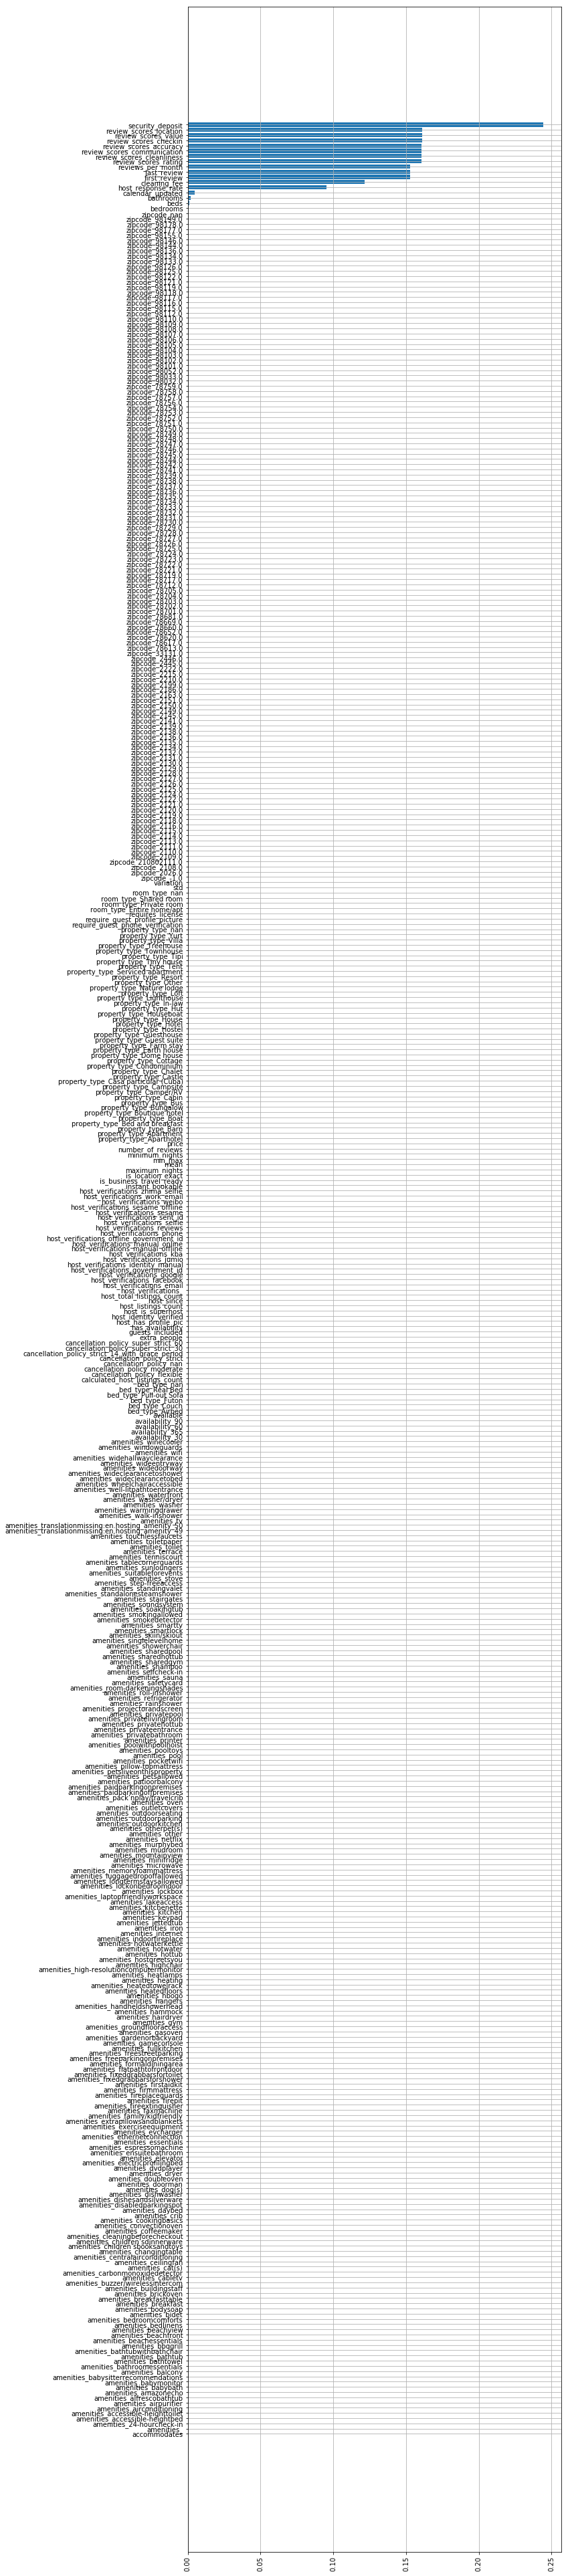

In [20]:
show_nan_percentage(test, figsize=(10, 70))

In [21]:
test = test.fillna(0)

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
targets_ = ["min_max", "variation", "available", "std", "mean"]
target = "bedrooms"

y = test[target]
X = test.drop(targets_ + [target], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
regressors = [XGBRegressor(n_jobs=-1, n_estimators=300)]
for regressor in regressors:
    regressor.fit(X_train, y_train)

In [56]:
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score
for regressor in regressors:
    y_pred = regressor.predict(X_test)
    mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
    ev = explained_variance_score(y_pred=y_pred, y_true=y_test)
    r2 = r2_score(y_pred=y_pred, y_true=y_test)
    print("Reegressor", regressor)
    print("MAE: {0}".format(mae))
    print("EV: {0}".format(ev))
    print("R2: {0}".format(r2))
    print()

Reegressor XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
MAE: 0.3235510964973165
EV: 0.8196969565236122
R2: 0.8195084733830094



In [58]:
results = pd.DataFrame(sorted(zip(regressors[0].feature_importances_, X.columns)), columns=["importance", "feature"])

In [59]:
results[results['importance'] > 0.01]

,importance,feature
415,0.010048,amenities_elevator
416,0.010048,zipcode_78702.0
417,0.011634,security_deposit
418,0.012163,calculated_host_listings_count
419,0.012163,extra_people
420,0.013749,host_response_rate
421,0.013749,property_type_House
422,0.014807,availability_365
423,0.015336,calendar_updated
424,0.016393,number_of_reviews
